In [ ]:
Perguntas

Qual é o perfil de quem assina o cartola?



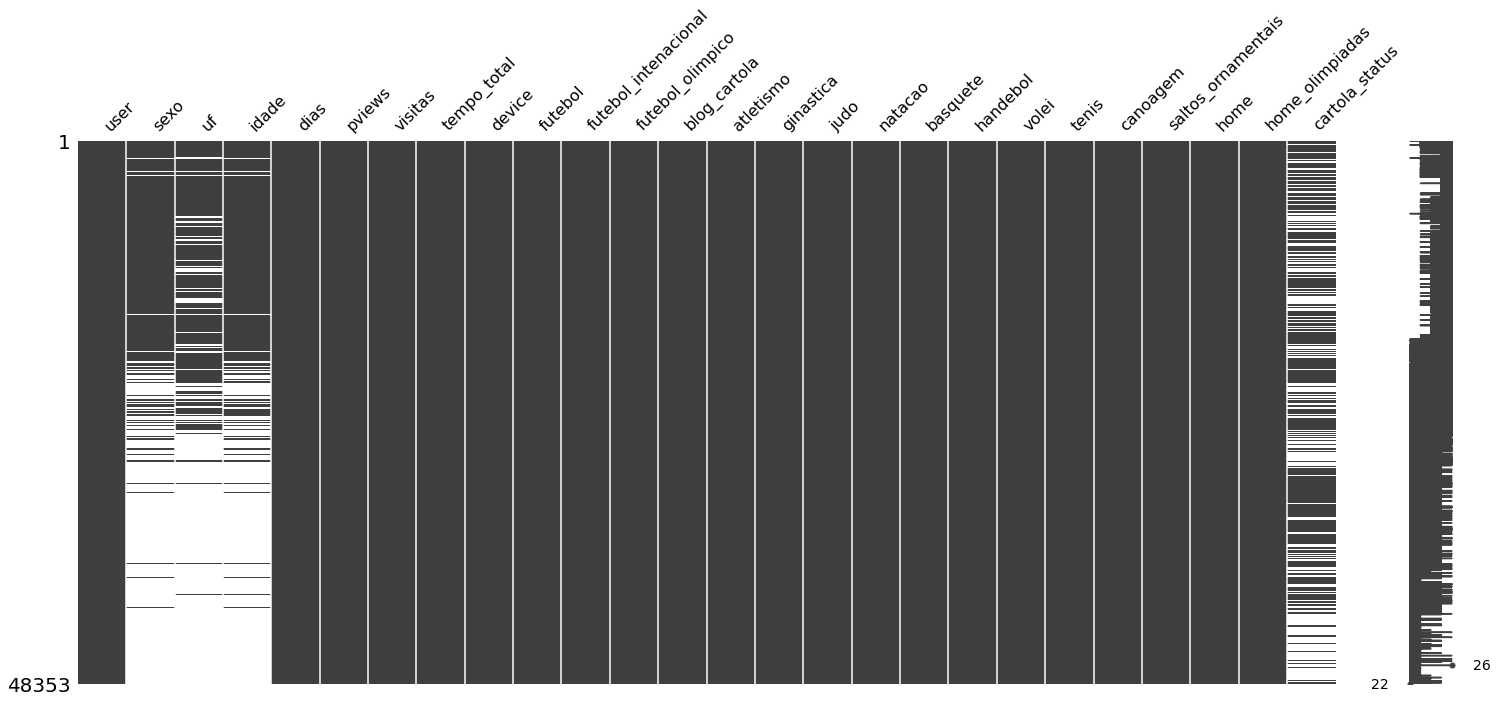

In [143]:
import pandas as pd
import missingno as msno 

df = pd.read_csv("./data/raw/ge_df_users_editorias_02.csv")
#Remover quem não usa o cartola para vermos primeiro o que leva um usuario do cartola a assinar
df = df[df['cartola_status']!="Não Cartola"]
msno.matrix(df)

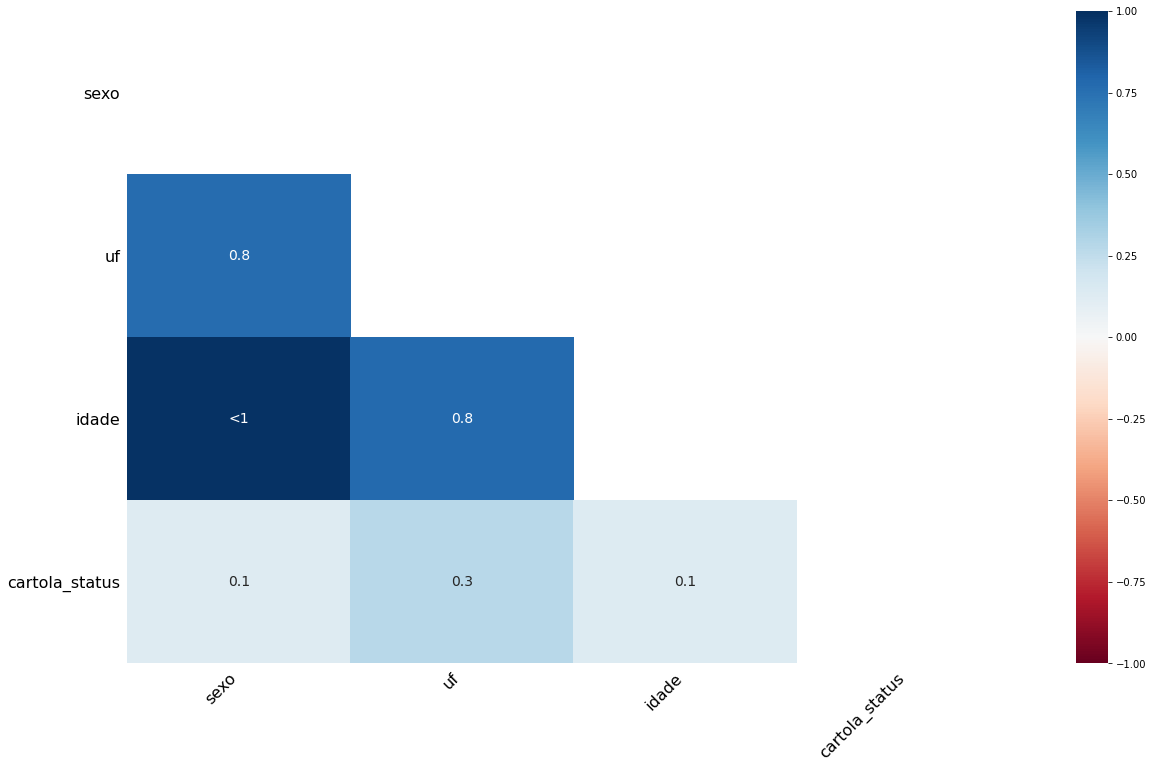

In [144]:
msno.heatmap(df) 

### Consideraçoes
* Aparentemente existe a possibilidade de se cadastrar sem informar dados pessoais como gênero, sexo e idade.
* Existe forte correlação entre quem escolhe não informar um desses campos, não informar os outros dois.
* A princípio não é um problema, podemos tentar inferir o sexo baseado no comportamento no aplicativo ou tratar como se existissem 3 tipos: M, F e Não Informado. 
* Antes de iniciar qualquer possível tratamento desses tipos, vamos ver qual é a importância de M e F num modelo.


In [ ]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = [x for x in model_data.columns if x not in [,'quality']]
norm_df = treated_df.iloc[:,1:12]
norm_df[cols_to_norm] = StandardScaler().fit_transform(treated_df[cols_to_norm])
sns.boxplot(data=norm_df)

Vamos dar labels para as colunas com variáveis categóricas

In [145]:
encoded_uf_df = pd.get_dummies(df[['sexo','idade','uf','cartola_status']], prefix_sep='_', drop_first=False)
encoded_uf_df

,idade,sexo_F,sexo_M,uf_Acre,uf_Alagoas,uf_Amapa,uf_Amazonas,uf_Bahia,uf_Ceara,uf_Distrito Federal,...,uf_Rio Grande do Sul,uf_Rio de Janeiro,uf_Rondonia,uf_Roraima,uf_Santa Catarina,uf_Sao Paulo,uf_Sergipe,uf_Tocantins,cartola_status_Cartola Free,cartola_status_Cartola Pro
3,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
43,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50684,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
50685,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
50686,27.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50687,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


AttributeError: 'Rectangle' object has no property 'cmap'

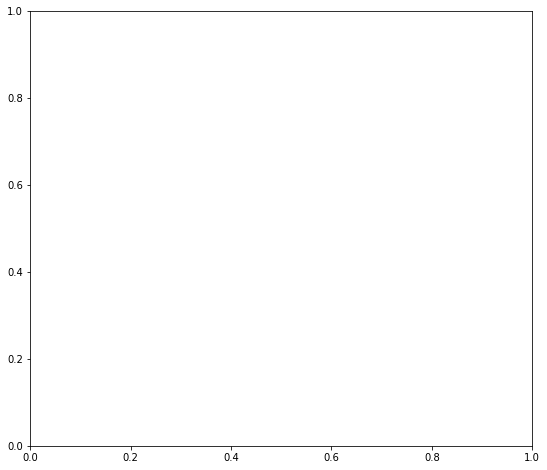

In [153]:
import seaborn as sns 
import matplotlib.pyplot as plt

# vamos analisar primeiro as variáveis dicotômicas::


filter_columns = [x for x in encoded_uf_df.columns if (x.startswith('uf') or x=='cartola_status_Cartola Pro')]
filter_columns.extend(['idade','sexo_F','sexo_M'])
corrmat = encoded_uf_df[filter_columns].corr(method = 'pearson')
#por que pearson? correlação binária

f, ax = plt.subplots(figsize =(9, 8)) 
sns.barplot(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

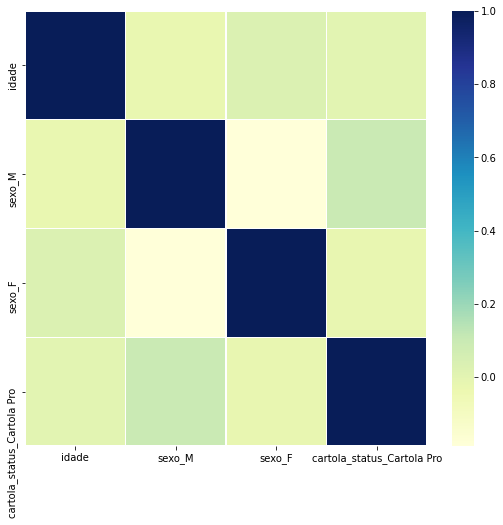

In [147]:
corrmat = encoded_uf_df[['idade','sexo_M','sexo_F','cartola_status_Cartola Pro']].corr()

f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

Idade sexo e estado por si só não estão correlacionados com a assinatura, mas podem estar correlacionados com outras variáveis que interessam.

* Por exemplo: Futebol é um dos fatores que mais levam as pessoas a assinarem o cartola, sendo que existe relação entre idade e gostar de futebol, novamente, como exemplo apenas.



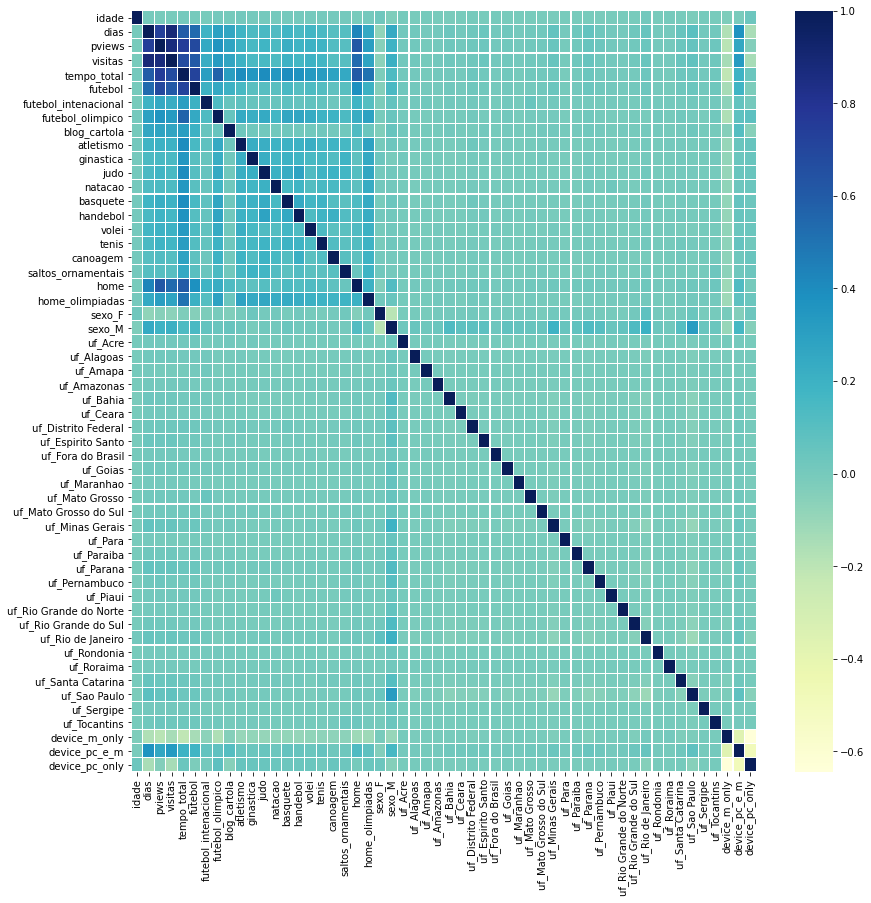

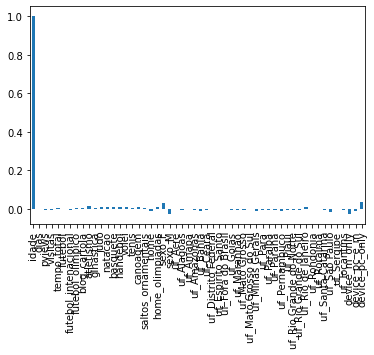

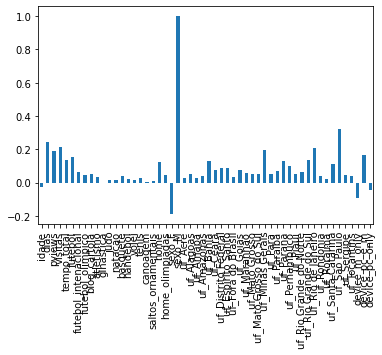

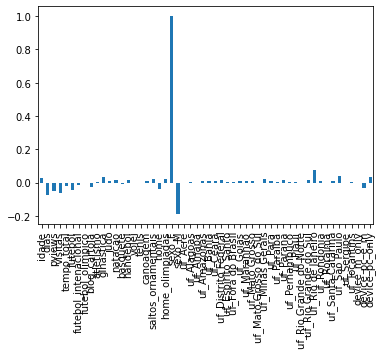

In [148]:
encoded_features_df = pd.get_dummies(df[[x for x in df.columns if x not in ['cartola_status','user']]], prefix_sep='_', drop_first=False)
encoded_features_df = encoded_features_df.replace("M", -1)
encoded_features_df = encoded_features_df.replace("F", 1)

corrmat = encoded_features_df.corr()
f, ax = plt.subplots(figsize =(14, 14)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
plt.show()


corrmat = encoded_features_df.corr()
corrmat['idade'].plot(kind = 'bar')
plt.show()

corrmat['sexo_M'].plot(kind = 'bar')
plt.show()

corrmat['sexo_F'].plot(kind = 'bar')
plt.show()

In [167]:
encoded_uf_df[encoded_uf_df['cartola_status_Cartola Pro']==1].sexo_F.value_counts()[1]

20

Não existe nenhuma correlação forte entre as características e comportamentos.
Apesar disso, podemos tomar algumas direções:

* O sexo masculino tem mais chances de assinar o Pro:
    * maior correlação direta, e também maior correlação com os comportamentos que levam à um possível assinante, tais como maior tempo gasto e futebol, por exemplo;
* Os estados SP, RJ e MG tem mais chances de assinar;
* Visitas e tempo gasto mostram importância;
* O tempo gasto na home e blog mostram importância;
* Futebol entre os esportes é o mais correlacionado com o usuário Pro;
* Usuários que acessam pelo pc e mobile tem mais chances de assinar.


Temos um guideline, vamos aos números

In [172]:
total_male = encoded_uf_df.sexo_M.value_counts()[1]
total_female = encoded_uf_df.sexo_M.value_counts()[1]
male_pro = encoded_uf_df[encoded_uf_df['cartola_status_Cartola Pro']==1].sexo_M.value_counts()[1]
female_pro = encoded_uf_df[encoded_uf_df['cartola_status_Cartola Pro']==1].sexo_F.value_counts()[1]

mf_prop = dict()
mf_prop['Homens'] = 100*(male_pro/total_male)
mf_prop['Mulheres'] = 100*(female_pro/total_female)
mf_prop
#A proporção de usuários homens assinantes é 4x a de usuários mulheres assinantes.

{'Homens': 3.927312447246909, 'Mulheres': 0.09929993545504194}

In [ ]:
O sexo masculino tem comportamentos um pouco mais bem definidos 

In [ ]:
Remover quem não usa o cartola

In [119]:
model_data = pd.get_dummies(df.iloc[:,4:], prefix_sep='_', drop_first = False)
model_data.describe()

,dias,pviews,visitas,tempo_total,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,atletismo,ginastica,...,canoagem,saltos_ornamentais,home,home_olimpiadas,device_m_only,device_pc_e_m,device_pc_only,cartola_status_Cartola Free,cartola_status_Cartola Pro,cartola_status_Não Cartola
count,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,...,50689.000000,50689.000000,50689.000000,50689.00000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000,50689.000000
mean,8.538085,56.689459,17.148415,12637.405687,3937.687461,274.015518,1156.293316,822.864136,347.241928,312.669947,...,141.100257,114.685967,1931.810051,650.79972,0.316696,0.211229,0.472075,0.572491,0.021247,0.046085
std,8.201193,109.424394,24.828745,27908.554735,11090.160922,2155.114900,4146.357108,4251.866684,2025.333697,2097.682553,...,1256.204387,1040.395728,7109.661917,3009.07565,0.465192,0.408185,0.499224,0.494722,0.144209,0.209671
min,1.000000,1.000000,1.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.000000,2.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,15.000000,7.000000,1671.576000,135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,13.565000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,13.000000,58.000000,21.000000,10349.220999,2366.065000,0.000000,209.871000,199.010000,8.068000,0.000000,...,0.000000,0.000000,569.675000,129.13200,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,31.000000,2143.000000,277.000000,225690.794000,187225.147000,161337.180000,176608.438000,196982.898000,104413.659000,144959.699000,...,106953.499000,84184.831000,192745.565000,101053.63500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.preprocessing import StandardScaler
cols_to_norm = [x for x in model_data.columns if x not in [,'quality']]
norm_df = treated_df.iloc[:,1:12]
norm_df[cols_to_norm] = StandardScaler().fit_transform(treated_df[cols_to_norm])
sns.boxplot(data=norm_df)

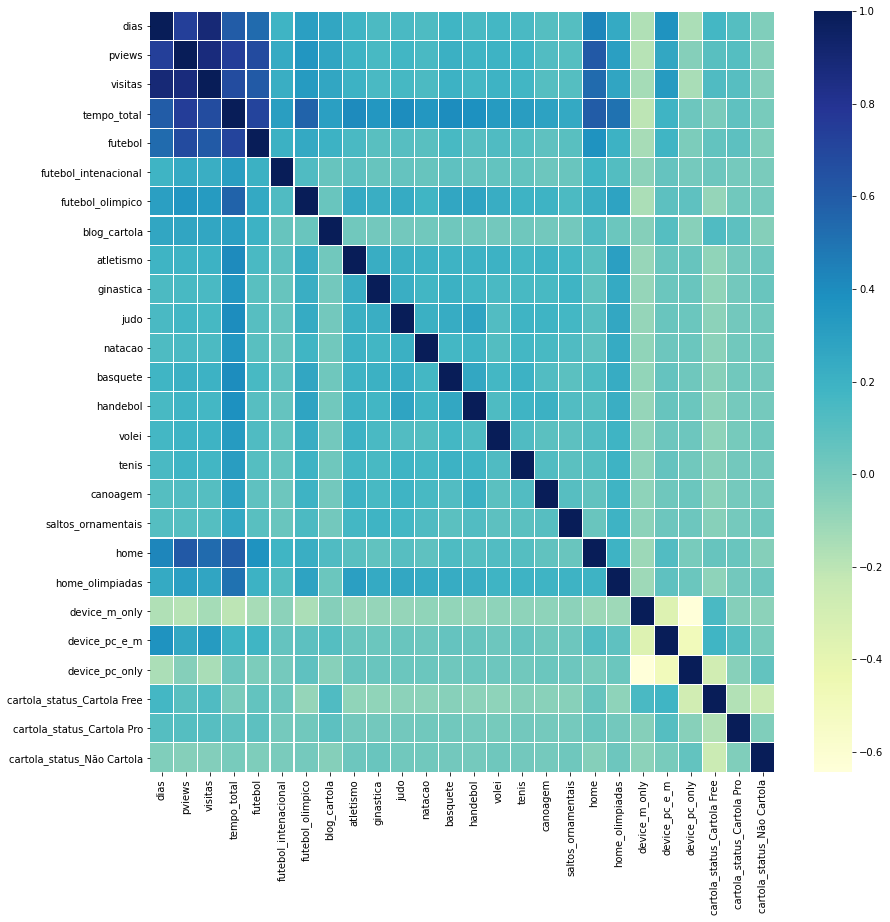

In [112]:
model_data = pd.get_dummies(df.iloc[:,4:], prefix_sep='_', drop_first = False)
corrmat = model_data.corr()
f, ax = plt.subplots(figsize =(14, 14)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
plt.show()
